In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import load_workbook

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# Вычисление метрик качества прогнозов
def Metrics(y, y_pred):
    
    mse = round(mean_squared_error(y, y_pred), 4)
    mae = round(np.mean(np.abs(y - y_pred)), 4)
    R2 = round(r2_score(y, y_pred), 4)
    
    return [mse, mae, R2]

# Формирование таблицы метрик на тренировочной и тестовой выборке
def MetricsDF(model, x_train, x_test, y_train, y_test, x_for, y_for, plot = False, savePath = ''):
    resDf = pd.DataFrame(index=['MSE', 'MAE', 'R2'], data = 
                         {'Train': Metrics(y_train, model.predict(x_train)),
                         'Test': Metrics(y_test, model.predict(x_test)),
                       'Forecast': Metrics(y_for, model.predict(x_for))})
    resDf.index.name = begin + ' — ' + end
    display(resDf)
    
    if plot:
        CompareGraph(y_for.index, y_for, model.predict(x_for), 'Истинные значения', 'Пронозируемые значения', 'Сравнение прогноза с истинными данными. Forecast')
    
    # Сохранение в файл
    if savePath:
        sheet_name = f'est = {model.n_estimators}, smpl =  {model.min_samples_split}'
        
        # Номер последней строки в файле
        numRow = 0
        wb = load_workbook(savePath)
        if sheet_name in wb.sheetnames:
            numRow = wb[sheet_name].max_row + 2
        
        with pd.ExcelWriter(savePath, engine="openpyxl", mode = 'a', if_sheet_exists='overlay') as writer:
            resDf.to_excel(writer, sheet_name = sheet_name, startrow = numRow)

# Сравнение графиков двух списков значений
def CompareGraph(x, y1, y2, l1, l2, title):
    plt.figure(figsize = (10, 4))
    plt.plot(x, y1, label = l1)
    plt.plot(x, y2, label = l2)

    plt.xlabel('time')
    plt.ylabel('PM 2.5, мкг/м³')
    plt.title(title)
    
    plt.legend()
    plt.grid()
    
    plt.show()

In [27]:
# Прогнозирование при помощи случайного леса
def RandForestForecast(sensor, fill, district, begin, end, predDays, estNum, min_samples_split = 5, plotRes = False, featImp = False, savePath = ''):
    
    # Данные pm за 4+ года
    df = pd.read_csv(f"pm25_{sensor}{fill}.csv", sep = ';', index_col = ['Date'], parse_dates = ['Date'], usecols = ['Date', district])[begin : end]
    df.rename(columns = {district : 'pm'}, inplace = True)

    features = ['Pressure', 'Temperature', 'Wet', 'Wind_dir', 'Wind_speed']
    for feat in features:
        df[feat] = pd.read_csv(f"Features{fill}/{feat}_{sensor}.csv", sep = ';', index_col = ['Date'], parse_dates = ['Date'], usecols = ['Date', district])[begin : end]

        # Проверка на пропуски
        nans = pd.isnull(df[begin : end].values).sum()
        if nans > 0:
            print(f'Пропуски в {feat} :', nans, '\n')
            return 
    
    # Добавление инверсий
    inversions = pd.read_csv(f"Inversions.csv", sep = ';', index_col = ['Date'], parse_dates = ['Date'])[begin : end]
    df = inversions.join(df)
    
    # Отрисовка PM
    '''plt.figure(figsize = (10, 4))
    plt.plot(df['pm'])
    
    plt.title(f'PM 2.5   {district}.    {begin} — {end}')
    plt.xlabel('Время (YYYY-MM-DD)')
    plt.ylabel('PM 2.5, мкг/м³')
    plt.grid()
    plt.show()'''
    
    # Разбиение данных
    x = df.drop(['pm'], axis = 1)[: -predDays]
    y = df['pm'][: -predDays]
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=100, test_size = 0.3)
    # Отложенная выборка для прогноза
    x_for, y_for = df.drop(['pm'], axis = 1)[-predDays: ], df['pm'][-predDays :]
    
    
    # Создаем модель
    rf = RandomForestRegressor(n_estimators = estNum, n_jobs=-1, random_state=100, min_samples_split = min_samples_split)
    # Обучаем
    rf.fit(x_train, y_train)

    MetricsDF(rf, x_train, x_test, y_train, y_test, x_for, y_for, plotRes, savePath)
    
    # Определение важности признаков
    if featImp: FeatureImportance(x, rf)
    
# Важность признаков
def FeatureImportance(data, model):
    # Упорядычиваем наши фичи по значениям весов, от самой полезной к самой бесполезной
    df_importances= sorted(list(zip(data.columns, model.feature_importances_.ravel())), key=lambda tpl: tpl[1], reverse=True)

    # Создаем табличку, в которой будет показан признак и его вес
    df_importances = pd.DataFrame(df_importances, columns=['feature', 'importance']) 

    # Нумируем колонки, чтобы не путать их
    df_importances = df_importances.set_index('feature')

    # Создаем график, чтобы было нагляднее
    df_importances.plot(kind='bar', figsize=(8, 3))

    plt.title('Важность признаков')
    # Рисуем график
    plt.show()

    # Выводим табличку
    display(df_importances)

In [25]:
sensor = 's'
fill = '_fill'

district = 'Mean'

# Срез данных от begin до end
begin, end = '2020-12-15', '2021-02-25'

# Количество дней прогнозирования (до end)
predDays = 5

In [23]:
# Список периодов пронгозирования для Mean при помощи ARIMAX
from os import listdir

,Train,Test,Forecast
2019-03-12 — 2019-05-10,,,
MSE,5.4274,36.6008,66.2371
MAE,1.9479,4.4176,6.7581
R2,0.9214,0.4706,-0.7264


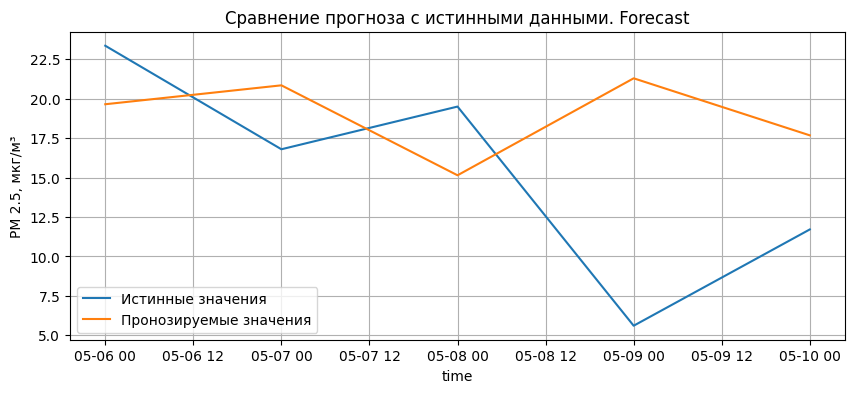

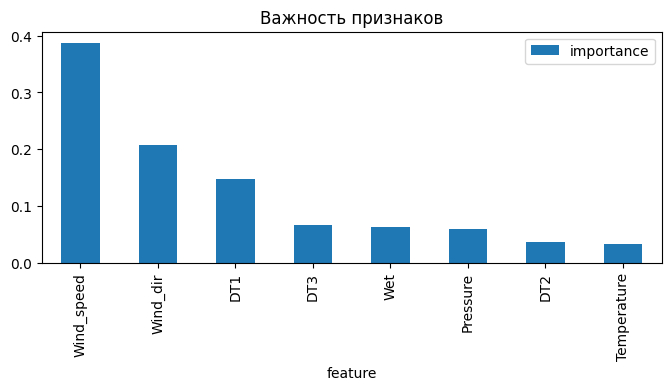

,importance
feature,
Wind_speed,0.387807
Wind_dir,0.207723
DT1,0.147996
DT3,0.066138
Wet,0.061993
Pressure,0.058554
DT2,0.037149
Temperature,0.032641


,Train,Test,Forecast
2019-05-10 — 2019-07-08,,,
MSE,3.5472,11.0920,12.5277
MAE,1.4056,2.1116,2.4069
R2,0.8600,0.5238,0.4868


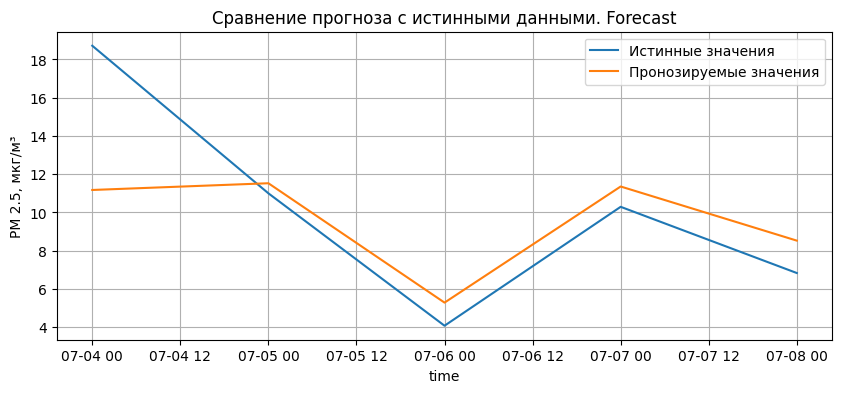

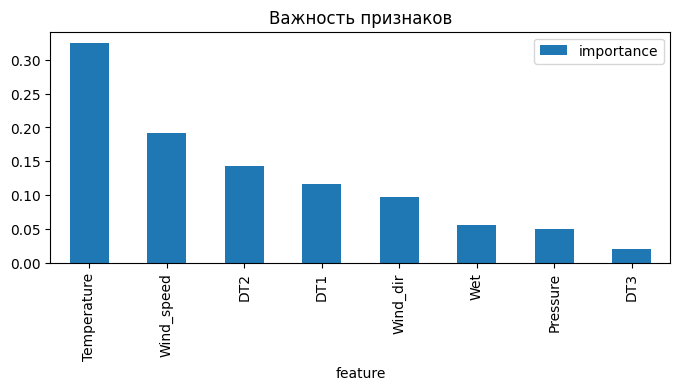

,importance
feature,
Temperature,0.325266
Wind_speed,0.192328
DT2,0.142719
DT1,0.115796
Wind_dir,0.097049
Wet,0.056145
Pressure,0.050359
DT3,0.020337


,Train,Test,Forecast
2019-08-28 — 2019-11-10,,,
MSE,3.3639,44.4472,20.5636
MAE,1.3926,4.1675,4.3419
R2,0.8963,0.3779,0.2616


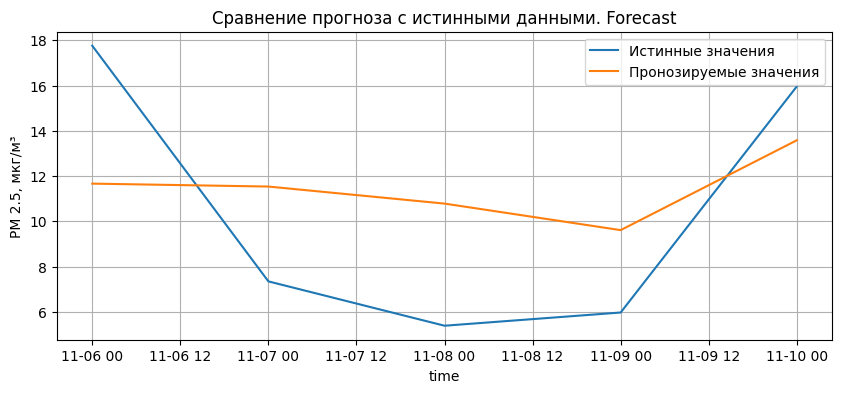

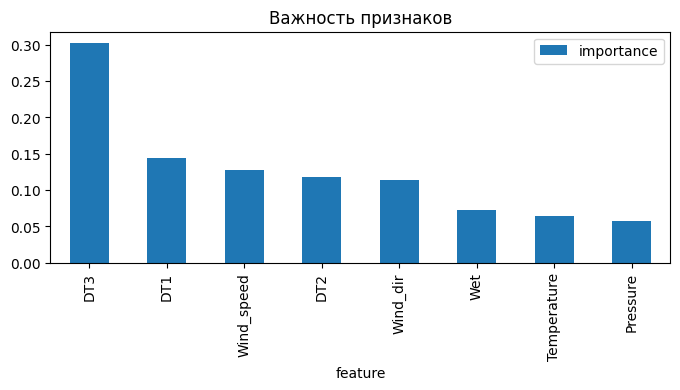

,importance
feature,
DT3,0.303211
DT1,0.143596
Wind_speed,0.127632
DT2,0.118162
Wind_dir,0.114082
Wet,0.071991
Temperature,0.063956
Pressure,0.057371


,Train,Test,Forecast
2019-11-25 — 2020-02-25,,,
MSE,19.5403,386.2938,1393.8704
MAE,3.1269,13.5917,34.1658
R2,0.9839,0.5492,-6.1672


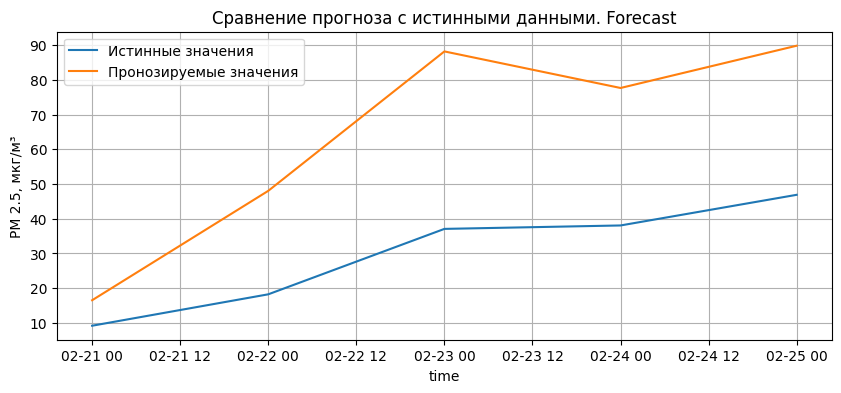

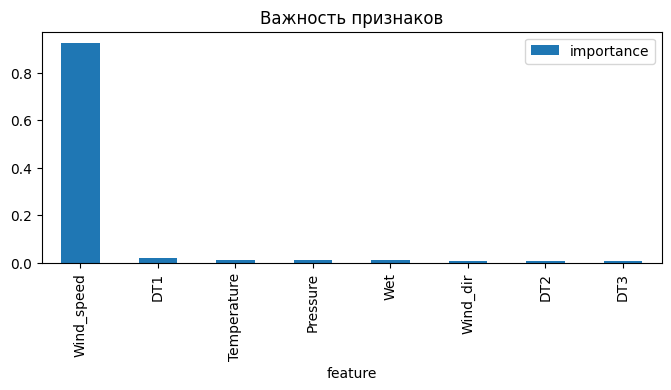

,importance
feature,
Wind_speed,0.926074
DT1,0.017751
Temperature,0.012789
Pressure,0.012658
Wet,0.011686
Wind_dir,0.007113
DT2,0.006602
DT3,0.005328


,Train,Test,Forecast
2020-03-15 — 2020-05-15,,,
MSE,3.5167,28.2737,112.2544
MAE,1.4601,4.1300,9.0377
R2,0.9597,0.6581,-2.9812


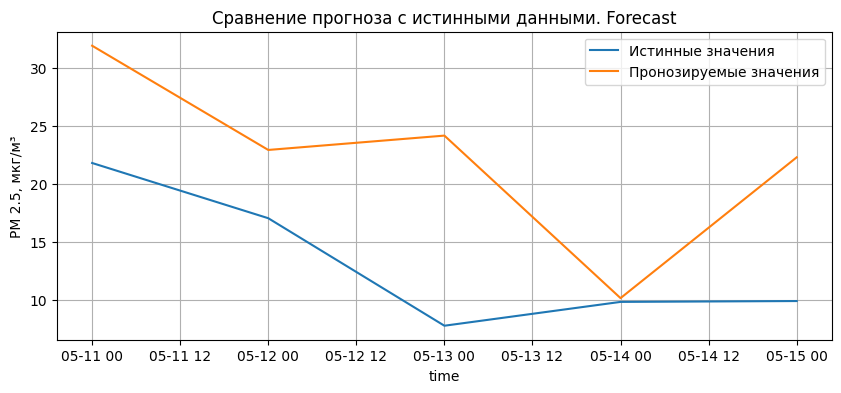

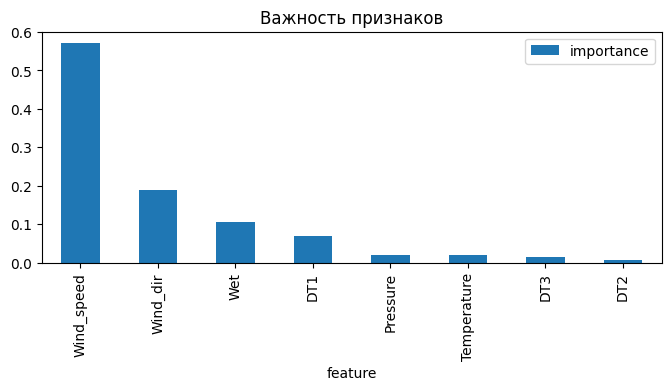

,importance
feature,
Wind_speed,0.572107
Wind_dir,0.189887
Wet,0.105859
DT1,0.068794
Pressure,0.020650
Temperature,0.019009
DT3,0.015661
DT2,0.008034


,Train,Test,Forecast
2020-05-01 — 2020-08-01,,,
MSE,1.4871,9.7201,8.9314
MAE,0.9417,2.5608,2.2597
R2,0.9067,0.5185,-7.7911


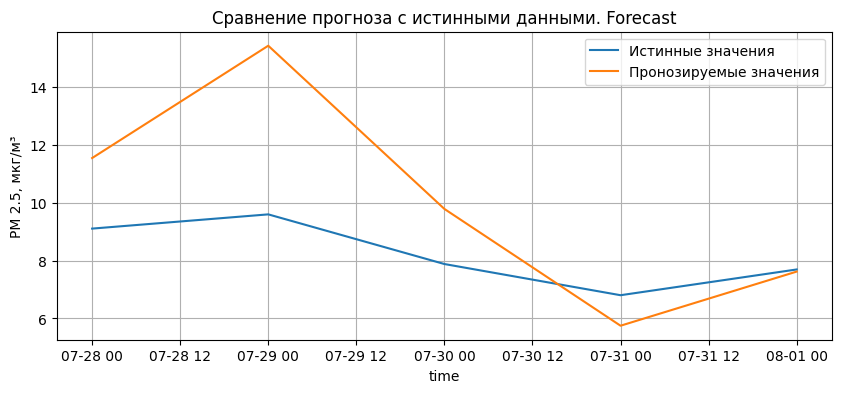

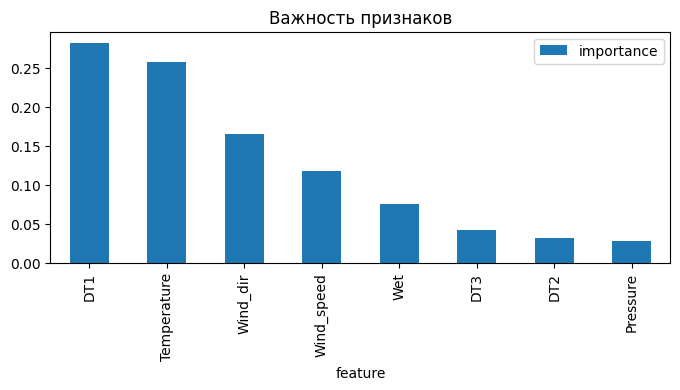

,importance
feature,
DT1,0.282840
Temperature,0.258045
Wind_dir,0.164854
Wind_speed,0.117465
Wet,0.074908
DT3,0.041839
DT2,0.032119
Pressure,0.027930


,Train,Test,Forecast
2020-05-15 — 2020-08-01,,,
MSE,1.4387,4.5615,7.0406
MAE,0.9563,1.7918,2.1217
R2,0.9115,0.5794,-5.9300


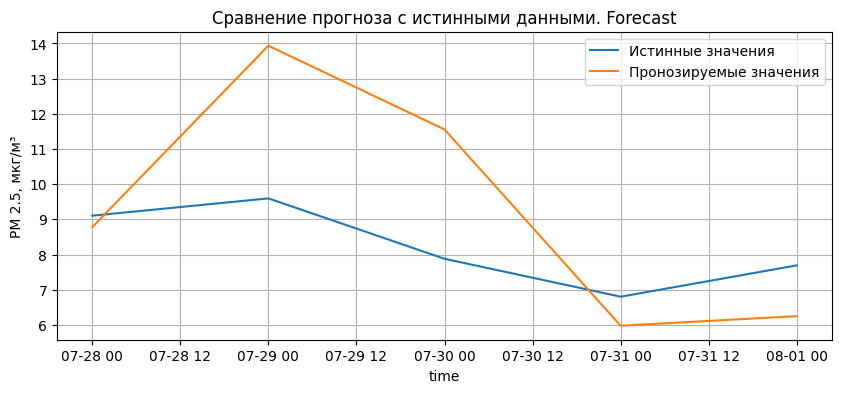

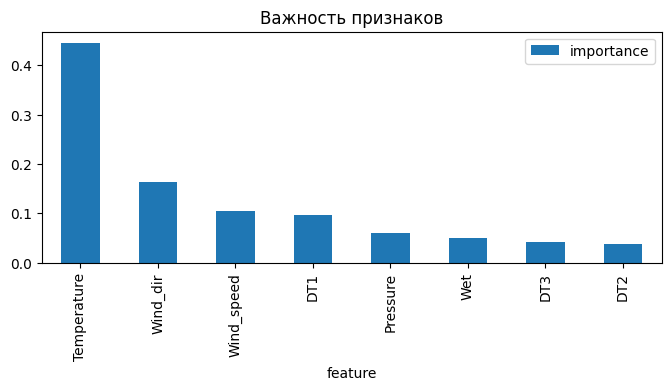

,importance
feature,
Temperature,0.445658
Wind_dir,0.162308
Wind_speed,0.105139
DT1,0.096932
Pressure,0.059549
Wet,0.049732
DT3,0.042106
DT2,0.038577


,Train,Test,Forecast
2020-08-01 — 2020-10-28,,,
MSE,4.6373,15.2971,31.3102
MAE,1.5215,2.8575,4.5401
R2,0.9249,0.7097,-3.3593


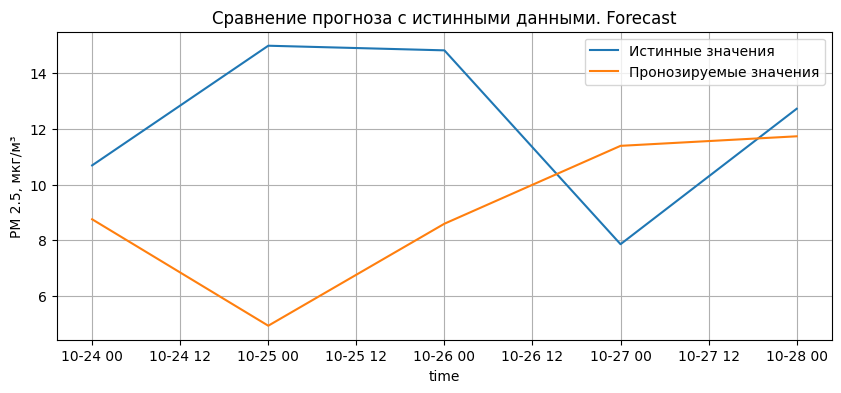

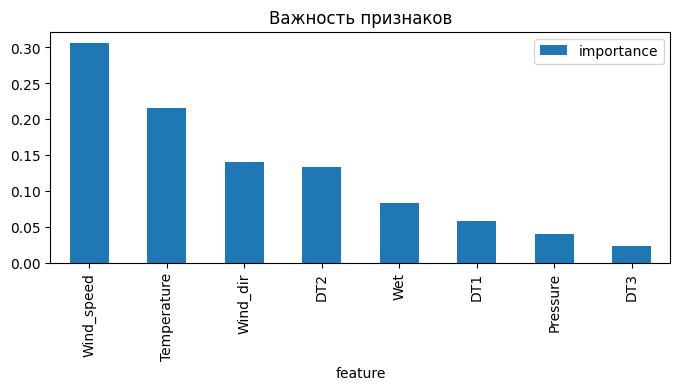

,importance
feature,
Wind_speed,0.306739
Temperature,0.215192
Wind_dir,0.139610
DT2,0.133862
Wet,0.083358
DT1,0.057987
Pressure,0.039619
DT3,0.023633


,Train,Test,Forecast
2020-12-15 — 2021-02-25,,,
MSE,93.7431,460.0154,723.6421
MAE,6.8281,16.1269,22.7699
R2,0.9562,0.7054,-0.1440


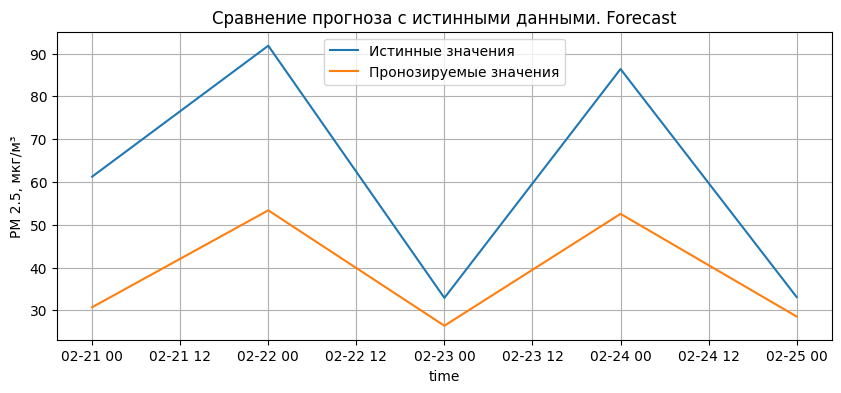

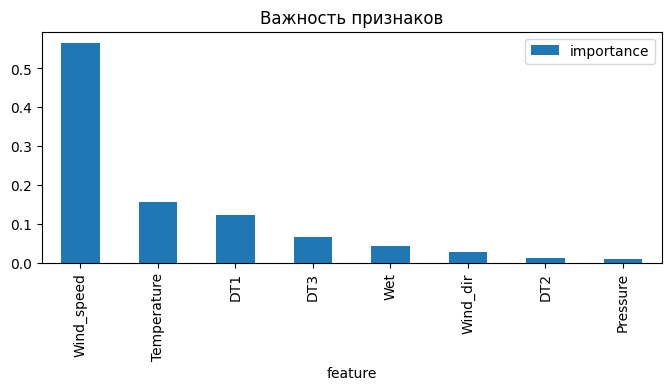

,importance
feature,
Wind_speed,0.566516
Temperature,0.155543
DT1,0.123510
DT3,0.065602
Wet,0.042004
Wind_dir,0.026410
DT2,0.011589
Pressure,0.008827


,Train,Test,Forecast
2021-04-01 — 2021-07-15,,,
MSE,4.1735,35.4619,18.0289
MAE,1.4059,4.1761,4.1818
R2,0.8602,0.2818,-13.2968


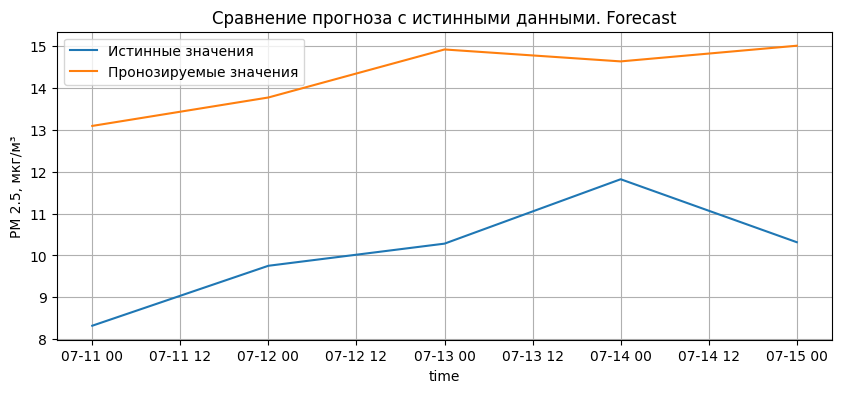

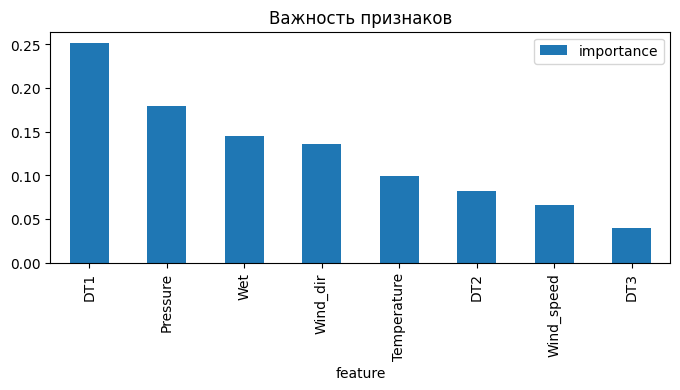

,importance
feature,
DT1,0.251979
Pressure,0.179838
Wet,0.145198
Wind_dir,0.136203
Temperature,0.098859
DT2,0.082343
Wind_speed,0.065527
DT3,0.040052


,Train,Test,Forecast
2021-08-15 — 2021-10-15,,,
MSE,2.1022,49.9617,104.2628
MAE,1.1250,5.4983,8.3494
R2,0.8776,0.2514,0.0188


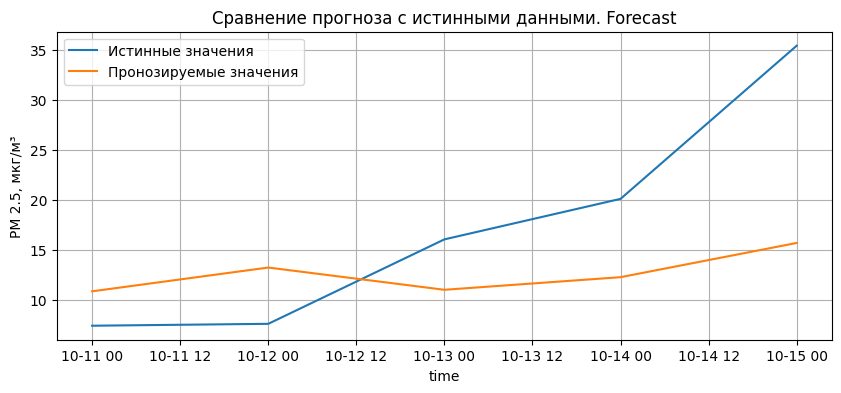

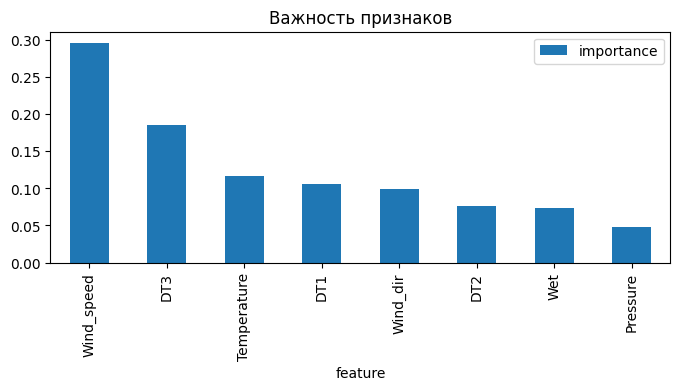

,importance
feature,
Wind_speed,0.296139
DT3,0.184867
Temperature,0.116827
DT1,0.105914
Wind_dir,0.098866
DT2,0.076687
Wet,0.073173
Pressure,0.047526


Пропуски в Wind_dir : 1 



,Train,Test,Forecast
2022-03-01 — 2022-05-12,,,
MSE,15.4878,43.3443,69.9192
MAE,2.2186,5.2548,7.3746
R2,0.8943,0.6332,-0.1558


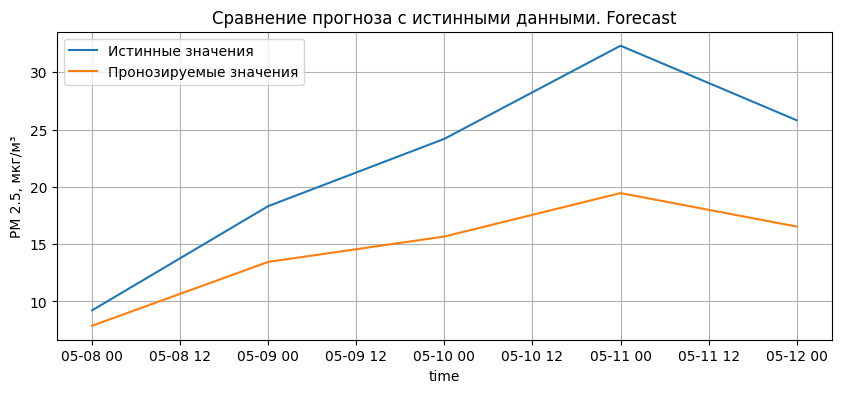

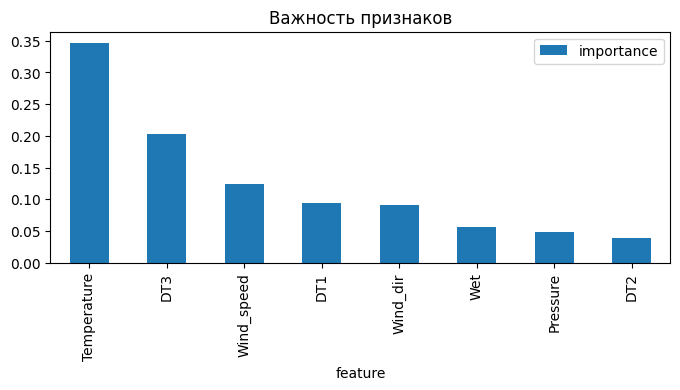

,importance
feature,
Temperature,0.347050
DT3,0.202290
Wind_speed,0.124046
DT1,0.093545
Wind_dir,0.090145
Wet,0.055842
Pressure,0.047614
DT2,0.039468


,Train,Test,Forecast
2022-04-01 — 2022-06-15,,,
MSE,13.3709,48.4409,79.7640
MAE,2.5415,5.8308,8.3026
R2,0.8503,0.2584,-11.3281


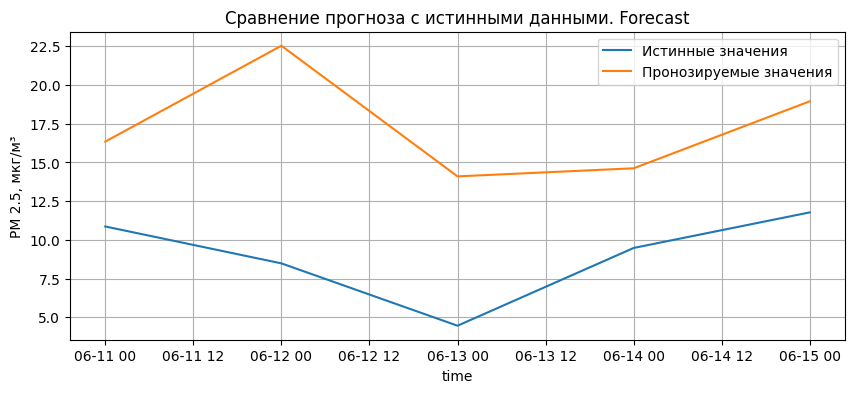

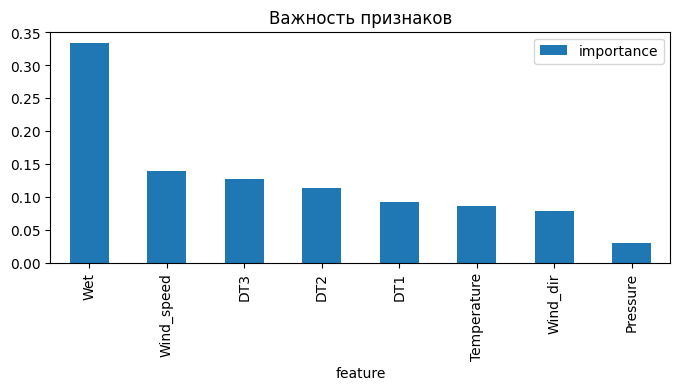

,importance
feature,
Wet,0.334507
Wind_speed,0.139231
DT3,0.126545
DT2,0.112946
DT1,0.092352
Temperature,0.085711
Wind_dir,0.078699
Pressure,0.030011


,Train,Test,Forecast
2022-07-16 — 2022-10-01,,,
MSE,2.2807,24.1793,3.5502
MAE,1.1342,3.3252,1.7140
R2,0.8830,0.4046,-0.4795


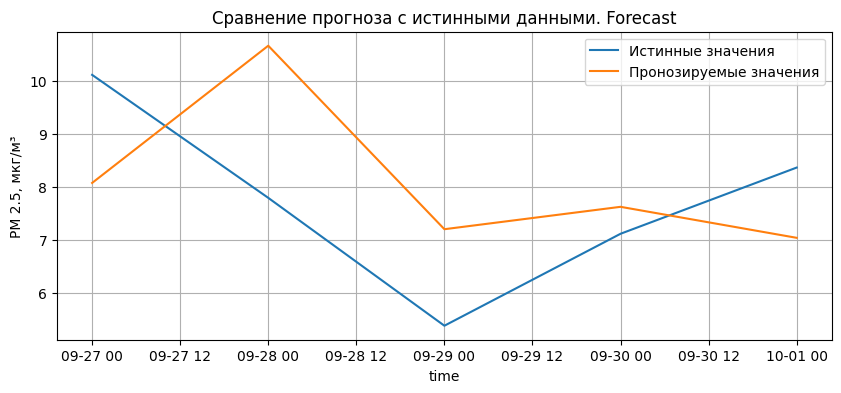

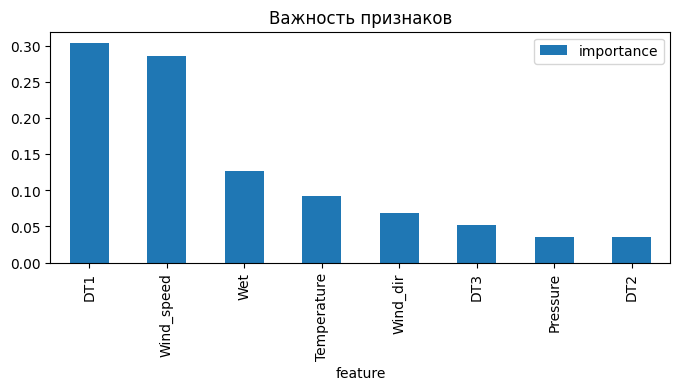

,importance
feature,
DT1,0.304443
Wind_speed,0.286091
Wet,0.126614
Temperature,0.091619
Wind_dir,0.068641
DT3,0.051869
Pressure,0.035592
DT2,0.035130


,Train,Test,Forecast
2022-12-01 — 2023-02-25,,,
MSE,101.5084,619.8685,1777.6544
MAE,7.6716,18.2764,38.4707
R2,0.9469,0.5461,-0.4408


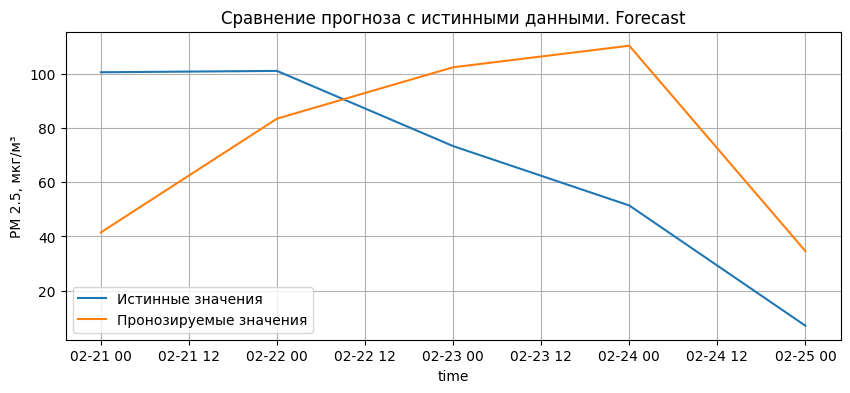

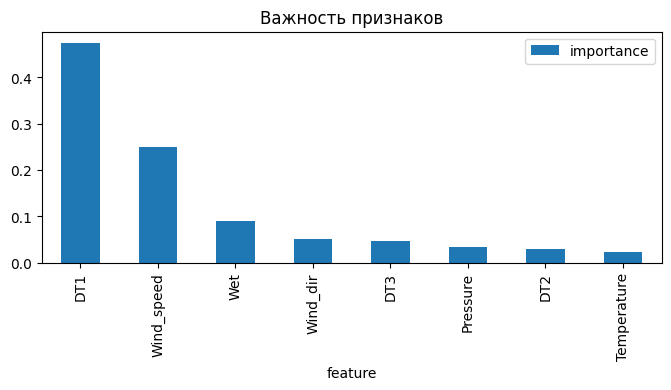

,importance
feature,
DT1,0.475410
Wind_speed,0.250741
Wet,0.089519
Wind_dir,0.050639
DT3,0.047247
Pressure,0.034770
DT2,0.028707
Temperature,0.022967


,Train,Test,Forecast
2023-02-25 — 2023-04-06,,,
MSE,29.8919,49.9049,4.2743
MAE,2.3236,5.1425,1.7450
R2,0.7850,0.7051,0.9327


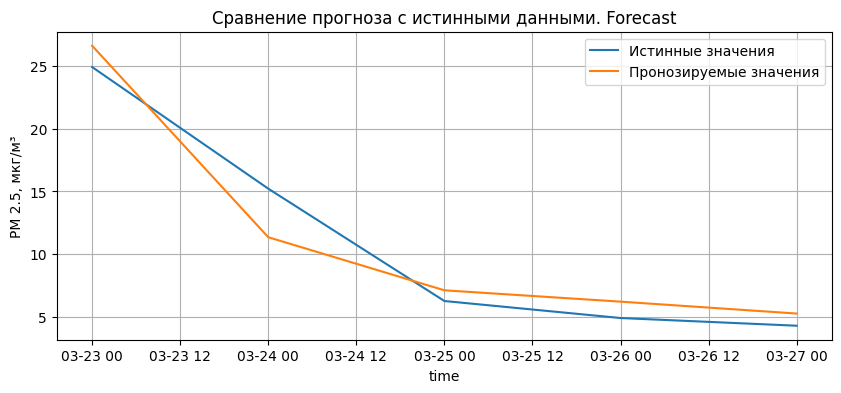

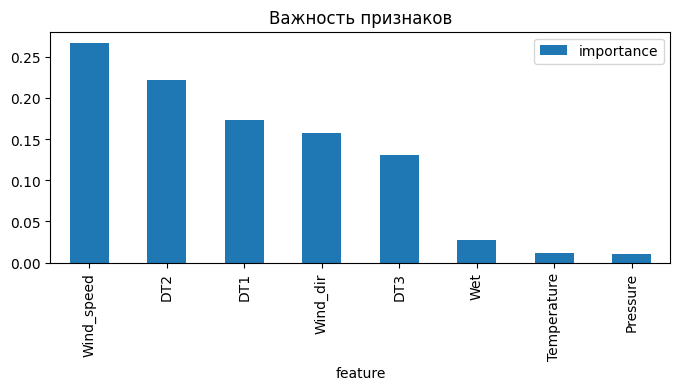

,importance
feature,
Wind_speed,0.267634
DT2,0.221535
DT1,0.173056
Wind_dir,0.157725
DT3,0.131104
Wet,0.027032
Temperature,0.012028
Pressure,0.009886


In [28]:
# Для всех периодов построить леса
for period in listdir('D:/Универ/Научная работа/2. Прогнозирование/Results/Mean_s'):
    begin, end = period.split(' — ')
    
    RandForestForecast(sensor, fill, district, begin, end, predDays, estNum = 50, min_samples_split = 3,
                       plotRes = True, featImp = True)

### Данные

### Лучшее качество прогнозирования на модели с 50 деревьями